In [1]:
import pandas as pd
import numpy as np
import re
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
import matplotlib.dates as mdates
from datetime import datetime
from numpyro.contrib.control_flow import scan
import matplotlib as mpl
import warnings
warnings.simplefilter('ignore')
import seaborn as sns

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# --------------------------------------------------------
# helper: draw one decomposition in an existing Axes
# --------------------------------------------------------
def plot_decomposition_ax(ax, date, original, trend, cycle, title, loc="upper left"):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # level & trend  ------------------------
    ax.plot(date, original, label="Original", color=colors[0])
    ax.plot(date, trend,    label="Trend",    color=colors[1])
    ax.set_xlabel("Year")
    ax.set_ylabel("level / trend")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)

    # cycle (twin axis) ---------------------
    ax2 = ax.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2])
    ax2.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax2.set_ylabel("Cycle")
    ax2.tick_params(axis="y", colors=colors[2])

    # legend (combine both axes) ------------
    lines  = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=loc, frameon=False)


/Users/satoshan/.pyenv/versions/miniforge3-4.10.3-10/envs/numpyro-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Clean Data

### Inflation rate (1947:Q1 - 2024:Q4)
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 


### Markup (1947:Q1 - 2017:Q4)
The Cyclical Behavior of the Price-Cost Markup

Christopher J. Nekarda (Board of Governors of the Federal Reserve System)

Valerie A. Ramey (University of California, San Diego and NBER)

paper: https://econweb.ucsd.edu/~vramey/research/markupcyc.pdf

data: https://econweb.ucsd.edu/~vramey/research.html

### Output and Output gap (1947:Q1 - 2024:Q4) 
- Output: GDPC1 (https://fred.stlouisfed.org/series/GDPC1)

- Output gap : Beveridge-Nelson Filter's cycle component of GDPC1 (https://bnfiltering.com)

### Inflation Expectation (1982Q1-2024)
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

1/4 $\times$ (one year inflation expectation)

### The number of Firm  (inverse of HHI)
- HHI World Integrated Trade Solution (WITS) of the World Bank (1988-2022)

(https://wits.worldbank.org/CountryProfile/en/country/by-country/startyear/ltst/endyear/ltst/indicator/HH-MKT-CNCNTRTN-NDX#)

quarterly HHI data obtained by linear interpolation of the original annual series

or

- Business Employment Dynamics (https://db.nomics.world/BLS/bd?tab=list)

quarterly log of the number of firm data obtained by linear interpolation of the original annual series and

---
$\pi_{t}$ : Inflation rate = ($\frac{\text{CPI}_{t} - \text{CPI}_{t-1}}{\text{CPI}_{t-1}}$)

$E_t[\hat{\pi}_{t+1}]$ : Quarterly Infration Expectation = $\frac{\text{one year inflation expectation}}{4}$

$\hat{Y}_t$ : Output gap = 100 * cycle of the Real Gross Domestic Product (GDPC1) in US (from BN filter)

$Y_t$ : Output = log of the Real Gross Domestic Product (GDPC1) in US * 0.01

$N_{t}$ : the number of establishments = log of (the number of establishments in US * 0.01)

or 

$N_{t}$ : the number of establishments = $1/HHI_t$

---

In [ ]:
# unemployment gap
# NROU
data_nairu = pd.read_csv("../data/NROU.csv")
data_nairu["DATE"] = pd.to_datetime(data_nairu["observation_date"])
# unemployment
data_unemp = pd.read_csv("../data/UNRATENSA.csv")
data_unemp["DATE"] = pd.to_datetime(data_unemp["observation_date"])
data_unempgap = pd.merge(data_nairu, data_unemp, on="DATE", how="outer")
data_unempgap['unemp_gap'] = data_unempgap['UNRATENSA'] - data_unempgap['NROU']
data_unempgap = data_unempgap.dropna()
data_unempgap = data_unempgap[["DATE", "unemp_gap"]]
data_unempgap

In [16]:
data_unempgap['unemp_gap'] = data_unempgap['UNRATENSA'] - data_unempgap['NROU']
data_unempgap = data_unempgap.dropna()
data_unempgap = data_unempgap[["DATE", "unemp_gap"]]
data_unempgap

,DATE,unemp_gap
4,1949-01-01,0.244947
5,1949-04-01,0.538484
6,1949-07-01,1.131987
7,1949-10-01,0.625436
8,1950-01-01,2.218818
...,...,...
305,2024-04-01,-0.521120
306,2024-07-01,-0.022554
307,2024-10-01,-0.421673
308,2025-01-01,0.079752


In [26]:
# Data
# cpi data
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])

# Markup data
data_markup = pd.read_excel("data/nekarda_ramey_markups.xlsx")
data_markup['DATE'] = pd.to_datetime(data_markup['qdate'], format='%Y-%m-%d')
data_markup['markup'] = data_markup['mu_bus']
data_markup = data_markup[['DATE', 'markup']].dropna()

# De-trended Markup data
data_markup_BN = pd.read_csv("data/BN_markup_inv.csv")
data_markup_BN['markup_BN_inv'] = data_markup_BN["cycle"] 
data_markup_BN['DATE'] = data_markup_BN["date"]
data_markup_BN = data_markup_BN[["DATE","markup_BN_inv"]].dropna()
data_markup_BN['DATE'] = pd.to_datetime(data_markup_BN['DATE'])

# output gap data
data_output = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_output['output_BN'] = data_output['GDPC1_transformed_series']
data_output['output_gap_BN'] = data_output["cycle"]
data_output['output'] = np.log(data_output["GDPC1_original_series"] * 0.01)
data_output['DATE'] = data_output["date"]
data_output["output_trend_BN"] = data_output["output_BN"] - data_output["output_gap_BN"]
data_output = data_output[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]].dropna()
data_output['DATE'] = pd.to_datetime(data_output['DATE'])

# inflation expectation data
data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

# HHI
data_N_annual = pd.read_excel("data/WITS-Country-Timeseries.xlsx")
data_N_annual["HHI"] = data_N_annual["Unnamed: 1"]
data_N_annual['year'] = pd.to_datetime(data_N_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_annual = data_N_annual.set_index('year')
data_N = data_N_annual.resample('QS').asfreq()
data_N['HHI'] = data_N['HHI'].interpolate(method='linear')
data_N = data_N.reset_index()
data_N['DATE'] = pd.to_datetime(data_N['year'])
data_N = data_N[["DATE", "HHI"]]
data_N["N"] = np.log(1/data_N["HHI"]) 
data_N.to_csv("data/N_HHI.csv", index=False)

# Merge all dataframes
data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_output, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")
data = pd.merge(data, data_markup, on="DATE", how="outer")
data = pd.merge(data, data_markup_BN, on="DATE", how="outer")
data["output_gap_BN"] = data["output_gap_BN"]
data["markup"] = data["markup"]
data["N"] = data["N"]

data["pi_prev"] = data["pi"].shift(1)
data["output_gap_prev"] = data["output_gap_BN"].shift(1)
data["markup_prev"] = data["markup"].shift(1)
data['N_prev'] = data['N'].shift(1)
data = data.dropna()
data_1 = data[data['DATE'] <= '2008-04-01']
data_2 = data[data['DATE'] > '2009-01-01']
# for MCMC
pi_1 = jnp.array(data_1['pi'],dtype=jnp.float64)
pi_prev_1 = jnp.array(data_1['pi_prev'],dtype=jnp.float64)
pi_expect_1 = jnp.array(data_1['Epi'],dtype=jnp.float64)
N_1 = jnp.array(data_1['N'],dtype=jnp.float64)
Y_1 = jnp.array(data_1['output'],dtype=jnp.float64)
x_markup_1 = jnp.array(1/data_1['markup'],dtype=jnp.float64)
x_output_gap_1 = jnp.array(data_1['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev_1 = jnp.array(data_1['output_gap_prev'],dtype=jnp.float64)
x_markup_prev_1 = jnp.array(1/data_1['markup_prev'],dtype=jnp.float64)

pi_2 = jnp.array(data_2['pi'],dtype=jnp.float64)
pi_prev_2 = jnp.array(data_2['pi_prev'],dtype=jnp.float64)
pi_expect_2 = jnp.array(data_2['Epi'],dtype=jnp.float64)
N_2 = jnp.array(data_2['N'],dtype=jnp.float64)
Y_2 = jnp.array(data_2['output'],dtype=jnp.float64)
x_markup_2 = jnp.array(1/data_2['markup'],dtype=jnp.float64)
x_output_gap_2 = jnp.array(data_2['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev_2 = jnp.array(data_2['output_gap_prev'],dtype=jnp.float64)
x_markup_prev_2 = jnp.array(1/data_2['markup_prev'],dtype=jnp.float64)

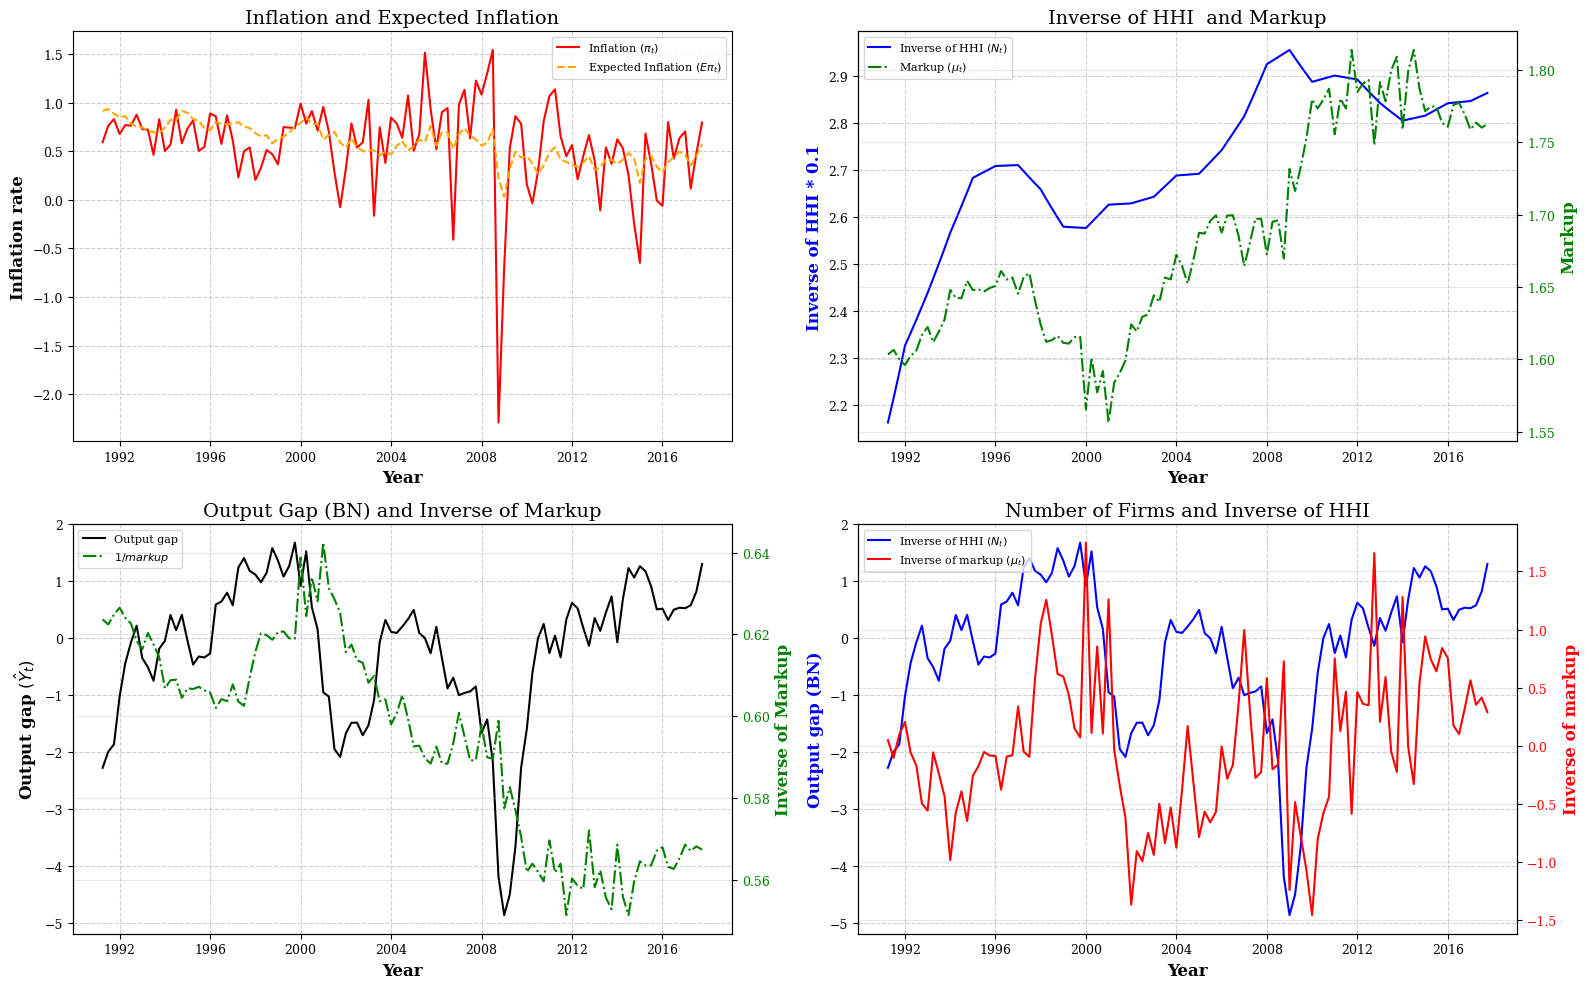

In [27]:

# --- 2×2 graph ---
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# --- 1. Inflation and Expected Inflation ---
ax1 = axs[0, 0]
ax1.plot(data["DATE"], data["pi"], label=r'Inflation $(\pi_{t})$', color='red')
ax1.plot(data["DATE"], data["Epi"], label=r'Expected Inflation $(E\pi_{t})$', linestyle='--', color='orange')
ax1.set_xlabel('Year', fontsize=12, weight='bold')
ax1.set_ylabel('Inflation rate', fontsize=12, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_title('Inflation and Expected Inflation', fontsize=14)
ax1.legend(fontsize=8)

# --- 2. Number of Firms and Markup ---
ax2 = axs[0, 1]
ax2_left = ax2
ax2_right = ax2_left.twinx()
ax2_left.plot(data["DATE"], data["N"], label=r'Inverse of HHI $(N_{t})$', color='blue')
ax2_right.plot(data["DATE"], data["markup"], label=r'Markup $(\mu_{t})$', linestyle='-.', color='green')
ax2_left.set_xlabel('Year', fontsize=12, weight='bold')
ax2_left.set_ylabel('Inverse of HHI * 0.1', fontsize=12, weight='bold', color = 'blue')
ax2_right.set_ylabel('Markup', fontsize=12, weight='bold', color='green')
ax2_right.tick_params(axis='y', labelcolor='green')
ax2_left.grid(True, linestyle='--', alpha=0.6)
ax2_left.set_title('Inverse of HHI  and Markup', fontsize=14)
lines = ax2_left.get_lines() + ax2_right.get_lines()
labels = [line.get_label() for line in lines]
ax2_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- 3. Output Gap and Inverse Markup ---
ax3 = axs[1, 0]
ax3_left = ax3
ax3_right = ax3_left.twinx()
ax3_left.plot(data["DATE"], data["output_gap_BN"], label='Output gap', color='black')
ax3_right.plot(data["DATE"], 1/data["markup"], label=r'$1/markup$', linestyle='-.', color='green')
ax3_left.set_xlabel('Year', fontsize=12, weight='bold')
ax3_left.set_ylabel(r'Output gap $(\hat{Y}_t)$', fontsize=12, weight='bold')
ax3_right.set_ylabel('Inverse of Markup', fontsize=12, weight='bold', color='green')
ax3_right.tick_params(axis='y', labelcolor='green')
ax3_left.grid(True, linestyle='--', alpha=0.6)
ax3_left.set_title('Output Gap (BN) and Inverse of Markup', fontsize=14)
lines = ax3_left.get_lines() + ax3_right.get_lines()
labels = [line.get_label() for line in lines]
ax3_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- 4. Inverse HHI and markup ---
ax4 = axs[1, 1]
ax4_left = ax4
ax4_right = ax4_left.twinx()
ax4_left.plot(data["DATE"], data["output_gap_BN"], label=r'Inverse of HHI $(N_{t})$', color='blue')
ax4_right.plot(data["DATE"], data["markup_BN_inv"], label=r'Inverse of markup $(\mu_{t})$', color='red')
ax4_left.set_xlabel('Year', fontsize=12, weight='bold')
ax4_left.set_ylabel('Output gap (BN)', fontsize=12, weight='bold', color='blue')
ax4_right.set_ylabel('Inverse of markup', fontsize=12, weight='bold', color='red')
ax4_right.tick_params(axis='y', labelcolor='red')
ax4_left.grid(True, linestyle='--', alpha=0.6)
ax4_left.set_title('Number of Firms and Inverse of HHI', fontsize=14)
lines = ax4_left.get_lines() + ax4_right.get_lines()
labels = [line.get_label() for line in lines]
ax4_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- Layout ---
plt.tight_layout()
plt.show()